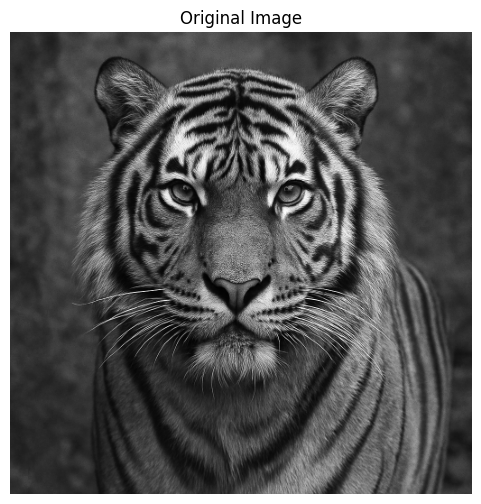

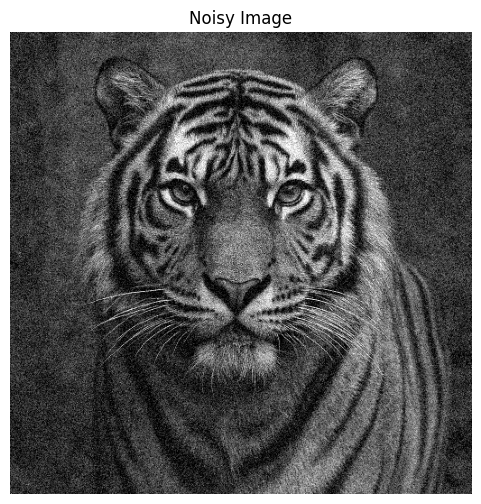

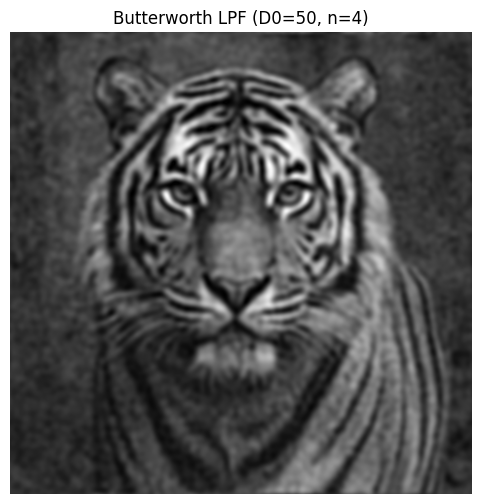

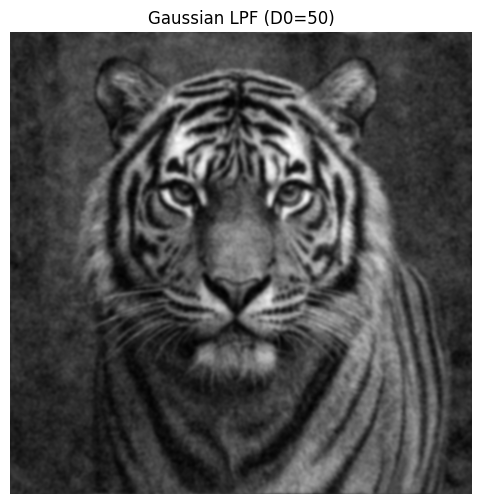

MSE (Butterworth vs Original): 272.96
MSE (Gaussian vs Original): 248.35


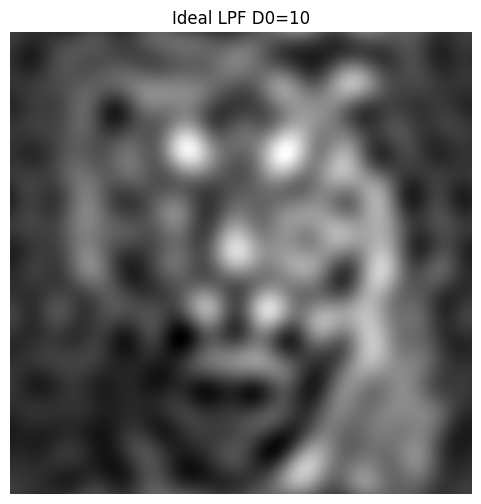

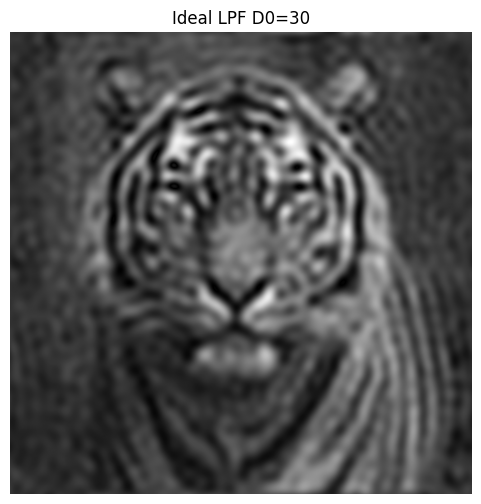

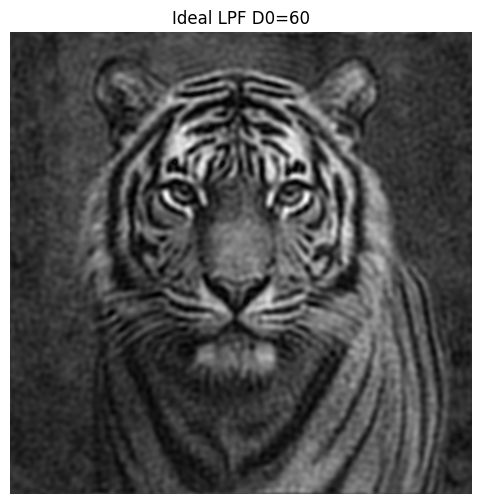

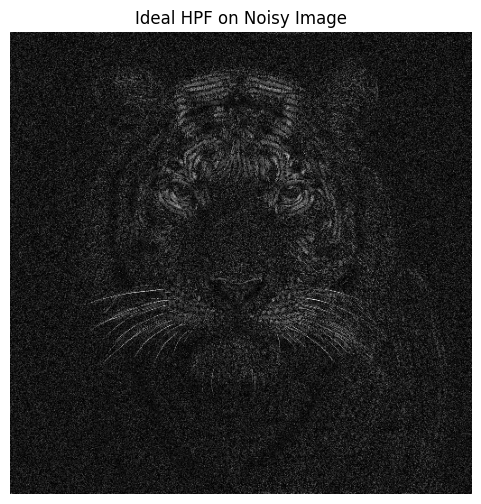

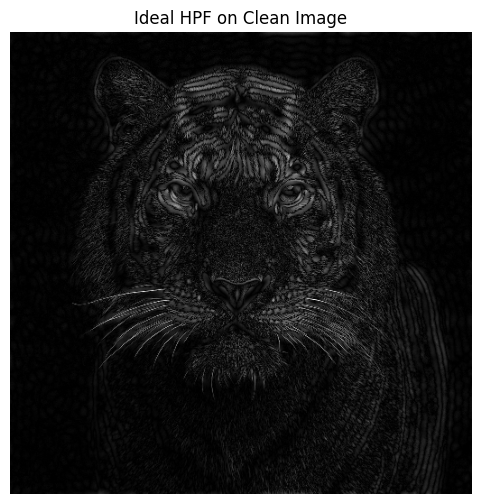

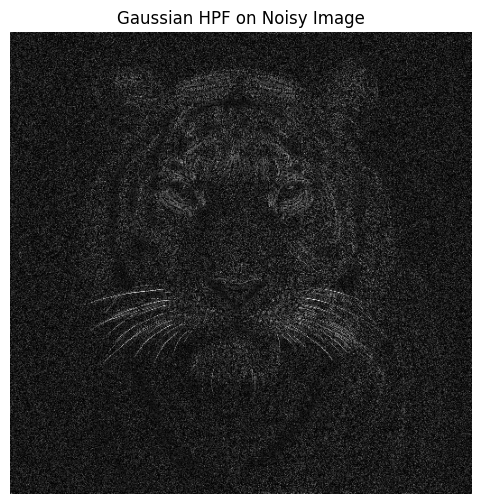

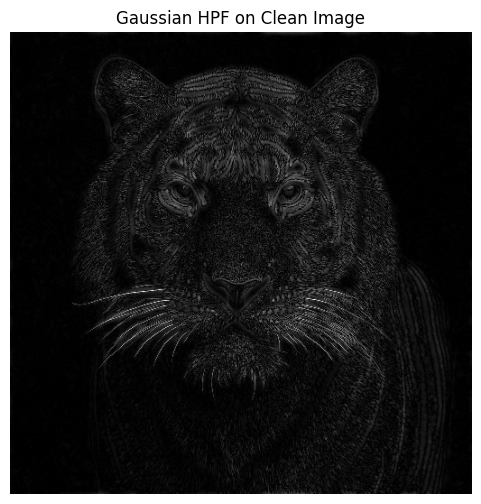

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utility function to display images
def show_image(title, img, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

# Load grayscale image
img = cv2.imread('images/tiger.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))
show_image("Original Image", img)

# Add Gaussian noise
mean = 0
std = 25
gaussian_noise = np.random.normal(mean, std, img.shape)
noisy_img = np.clip(img + gaussian_noise, 0, 255).astype(np.uint8)
show_image("Noisy Image", noisy_img)

# Perform FFT
def fft_image(image):
    dft = np.fft.fft2(image)
    return np.fft.fftshift(dft)

# Perform IFFT
def ifft_image(freq_img):
    f_ishift = np.fft.ifftshift(freq_img)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

# Create filters
def butterworth_lowpass(shape, D0, n):
    P, Q = shape
    u, v = np.meshgrid(np.arange(Q), np.arange(P))
    u = u - Q/2
    v = v - P/2
    D = np.sqrt(u**2 + v**2)
    H = 1 / (1 + (D / D0)**(2*n))
    return H

def gaussian_lowpass(shape, D0):
    P, Q = shape
    u, v = np.meshgrid(np.arange(Q), np.arange(P))
    u = u - Q/2
    v = v - P/2
    D = np.sqrt(u**2 + v**2)
    H = np.exp(-(D**2) / (2*(D0**2)))
    return H

def ideal_lowpass(shape, D0):
    P, Q = shape
    u, v = np.meshgrid(np.arange(Q), np.arange(P))
    u = u - Q/2
    v = v - P/2
    D = np.sqrt(u**2 + v**2)
    H = np.zeros_like(D)
    H[D <= D0] = 1
    return H

def ideal_highpass(shape, D0):
    return 1 - ideal_lowpass(shape, D0)

def gaussian_highpass(shape, D0):
    return 1 - gaussian_lowpass(shape, D0)

# (a) Apply Butterworth and Gaussian Low Pass Filters
def apply_filter(image, filter_func, *args):
    freq = fft_image(image)
    H = filter_func(image.shape, *args)
    filtered_freq = freq * H
    filtered_img = ifft_image(filtered_freq)
    return filtered_img, H

butter_img, butter_H = apply_filter(noisy_img, butterworth_lowpass, 50, 4)
gauss_img, gauss_H = apply_filter(noisy_img, gaussian_lowpass, 50)

show_image("Butterworth LPF (D0=50, n=4)", butter_img)
show_image("Gaussian LPF (D0=50)", gauss_img)

# Quantitative Comparison (e.g., MSE)
def mse(img1, img2):
    return np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)

print(f"MSE (Butterworth vs Original): {mse(img, butter_img):.2f}")
print(f"MSE (Gaussian vs Original): {mse(img, gauss_img):.2f}")

# (b) Observe Ringing Effect using Ideal LPF
for D0 in [10, 30, 60]:
    ideal_img, _ = apply_filter(noisy_img, ideal_lowpass, D0)
    show_image(f"Ideal LPF D0={D0}", ideal_img)

# (c) Edge Detection using High Pass Filters
# Ideal HPF
ideal_hp_img_noise, _ = apply_filter(noisy_img, ideal_highpass, 30)
ideal_hp_img_clean, _ = apply_filter(img, ideal_highpass, 30)

# Gaussian HPF
gauss_hp_img_noise, _ = apply_filter(noisy_img, gaussian_highpass, 30)
gauss_hp_img_clean, _ = apply_filter(img, gaussian_highpass, 30)

# Display
show_image("Ideal HPF on Noisy Image", ideal_hp_img_noise)
show_image("Ideal HPF on Clean Image", ideal_hp_img_clean)
show_image("Gaussian HPF on Noisy Image", gauss_hp_img_noise)
show_image("Gaussian HPF on Clean Image", gauss_hp_img_clean)
